# MAUDE FDA Device Adverse Event Reports – Web Scraping & Analysis

This notebook demonstrates how to scrape medical device adverse event data from the FDA's openFDA API using Python. After collecting the data based on a specific device product code (PCode), we perform data cleaning and simple exploratory visualizations to extract insights.


## Step 1: Web Scraping with openFDA API

We use Python's `requests` library to query the MAUDE database through the openFDA API. Data is pulled in paginated form and merged into a single DataFrame.


In [ ]:
import requests
import json

def fetch_maude_data(pcode, base_url="https://api.fda.gov/device/event.json", limit=100):
    results = []
    skip = 0

    while True:
        params = {
            "search": f"device.device_report_product_code:{pcode}",
            "limit": limit,
            "skip": skip
        }

        try:
            response = requests.get(base_url, params=params)
            response.raise_for_status()
            data = response.json()

            batch = data.get("results", [])
            if not batch:
                break

            results.extend(batch)
            skip += limit

        except requests.exceptions.RequestException as e:
            print(f"[!] Failed to fetch data: {e}")
            break

    return results


## Step 2: Data Preprocessing

We convert raw JSON data into structured tabular form using `pandas`. Then, we normalize nested fields and extract relevant columns for further analysis.


In [1]:
import os
import json
import pandas as pd
from glob import glob
from pprint import pprint


In [2]:
# List all JSON files in the data directory

json_files = glob("data/*.json")
print(f"{len(json_files)} JSON dosyası bulundu.")
pprint(json_files)


3 JSON dosyası bulundu.
['data\\GEH_20250520_011518.json',
 'data\\LLZ_20250520_011418.json',
 'data\\OSH_20250520_011427.json']


In [3]:
# Read and normalize all JSON files
df_list = []

for file in json_files:
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
        df = pd.json_normalize(data)
        df_list.append(df)

# Combine all into a single DataFrame
combined_df = pd.concat(df_list, ignore_index=True)

print(f"Total number of records: {combined_df.shape[0]}")



Total number of records: 22283


In [4]:
combined_df.head()

,manufacturer_contact_zip_ext,manufacturer_g1_address_2,event_location,report_to_fda,manufacturer_contact_t_name,manufacturer_contact_state,manufacturer_link_flag,manufacturer_contact_address_2,manufacturer_g1_city,manufacturer_contact_address_1,...,distributor_zip_code,manufacturer_contact_postal_code,manufacturer_contact_exchange,manufacturer_contact_pcountry,suppl_dates_fda_received,report_date,date_report_to_fda,device_date_of_manufacturer,date_facility_aware,date_report_to_manufacturer
0,,,I,*,,,Y,,,,...,,,,,09/04/2020,NaN,NaN,NaN,NaN,NaN
1,,,I,*,,,Y,,,,...,,,,,07/16/2020,NaN,NaN,NaN,NaN,NaN
2,,,HOSPITAL,Y,,,N,,,,...,,,,,,20071105,20071106,NaN,NaN,NaN
3,,,,,,CA,Y,,,4696 WILLOW RD.,...,,94588,925,,,NaN,NaN,20070601,NaN,NaN
4,,,I,*,,,Y,,,,...,,,,,09/30/2020,NaN,NaN,NaN,NaN,NaN


In [5]:
# Show all column names
print("List of all columns:")
pprint(combined_df.columns.tolist())


List of all columns:
['manufacturer_contact_zip_ext',
 'manufacturer_g1_address_2',
 'event_location',
 'report_to_fda',
 'manufacturer_contact_t_name',
 'manufacturer_contact_state',
 'manufacturer_link_flag',
 'manufacturer_contact_address_2',
 'manufacturer_g1_city',
 'manufacturer_contact_address_1',
 'manufacturer_contact_pcity',
 'event_type',
 'report_number',
 'type_of_report',
 'product_problem_flag',
 'date_received',
 'manufacturer_address_2',
 'pma_pmn_number',
 'date_of_event',
 'reprocessed_and_reused_flag',
 'manufacturer_address_1',
 'exemption_number',
 'manufacturer_contact_zip_code',
 'reporter_occupation_code',
 'manufacturer_contact_plocal',
 'noe_summarized',
 'manufacturer_contact_l_name',
 'source_type',
 'distributor_zip_code_ext',
 'manufacturer_g1_postal_code',
 'manufacturer_g1_state',
 'reporter_country_code',
 'manufacturer_contact_area_code',
 'date_added',
 'manufacturer_contact_f_name',
 'previous_use_code',
 'device',
 'product_problems',
 'manufacture

In [6]:
# Count missing values per column
missing_values = combined_df.isnull().sum()
missing_ratio = (missing_values / len(combined_df)) * 100

missing_df = pd.DataFrame({
    "Missing Count": missing_values,
    "Missing Ratio (%)": missing_ratio
})

# Sort columns by most missing values
missing_df = missing_df[missing_df["Missing Count"] > 0].sort_values(by="Missing Count", ascending=False)

print("Columns with missing values:")
missing_df


Columns with missing values:


,Missing Count,Missing Ratio (%)
date_facility_aware,22188,99.573666
date_report_to_manufacturer,22150,99.403132
date_report_to_fda,22137,99.344792
report_date,21510,96.530988
product_problems,18961,85.091774
device_date_of_manufacturer,3211,14.410088
date_manufacturer_received,855,3.837006
date_of_event,643,2.885608
date_report,157,0.704573
date_added,2,0.008975


In [7]:
# Check data types
print("Data types of each column:")
combined_df.dtypes.value_counts()


Data types of each column:


object    88
Name: count, dtype: int64

In [8]:
# Drop columns with more than 95% missing values
threshold = 0.95
missing_ratio = combined_df.isnull().mean()
mostly_missing_cols = missing_ratio[missing_ratio > threshold].index.tolist()

# Drop address-related and irrelevant columns manually
irrelevant_cols = [col for col in combined_df.columns if any(x in col.lower() for x in [
    "address", "phone", "zip", "city", "state", "fax", "country", "postal", "name_1", "name_2"
])]

# Combine all columns to drop
cols_to_drop = list(set(mostly_missing_cols + irrelevant_cols))
print(f"Columns to drop ({len(cols_to_drop)} total):")
pprint(cols_to_drop)

# Drop from DataFrame
combined_df_cleaned = combined_df.drop(columns=cols_to_drop)
print(f"Remaining columns: {combined_df_cleaned.shape[1]}")


Columns to drop (38 total):
['manufacturer_contact_address_2',
 'manufacturer_contact_pcity',
 'reporter_country_code',
 'manufacturer_g1_city',
 'manufacturer_g1_address_2',
 'manufacturer_g1_postal_code',
 'date_report_to_fda',
 'distributor_zip_code',
 'manufacturer_contact_zip_ext',
 'manufacturer_address_1',
 'manufacturer_g1_address_1',
 'manufacturer_address_2',
 'manufacturer_zip_code',
 'distributor_state',
 'manufacturer_g1_country',
 'manufacturer_state',
 'manufacturer_contact_city',
 'manufacturer_country',
 'manufacturer_contact_postal_code',
 'manufacturer_contact_phone_number',
 'date_facility_aware',
 'date_report_to_manufacturer',
 'manufacturer_contact_country',
 'manufacturer_g1_zip_code_ext',
 'manufacturer_g1_zip_code',
 'distributor_address_1',
 'manufacturer_postal_code',
 'manufacturer_contact_pcountry',
 'manufacturer_contact_address_1',
 'manufacturer_contact_zip_code',
 'manufacturer_contact_state',
 'distributor_city',
 'distributor_zip_code_ext',
 'manufac

In [9]:
# Convert columns containing 'date' to datetime
date_columns = [col for col in combined_df_cleaned.columns if 'date' in col.lower()]
print("Date columns to convert:", date_columns)

for col in date_columns:
    combined_df_cleaned[col] = pd.to_datetime(combined_df_cleaned[col], errors='coerce')

# Show how many missing values remain in these after conversion
print("\nMissing values in date columns after conversion:")
print(combined_df_cleaned[date_columns].isnull().sum())


Date columns to convert: ['date_received', 'date_of_event', 'date_added', 'suppl_dates_mfr_received', 'date_changed', 'date_report', 'date_manufacturer_received', 'suppl_dates_fda_received', 'device_date_of_manufacturer']

Missing values in date columns after conversion:
date_received                      0
date_of_event                    643
date_added                         2
suppl_dates_mfr_received       20960
date_changed                       0
date_report                      157
date_manufacturer_received       860
suppl_dates_fda_received       20670
device_date_of_manufacturer     3211
dtype: int64


## STEP 3: Visualizations

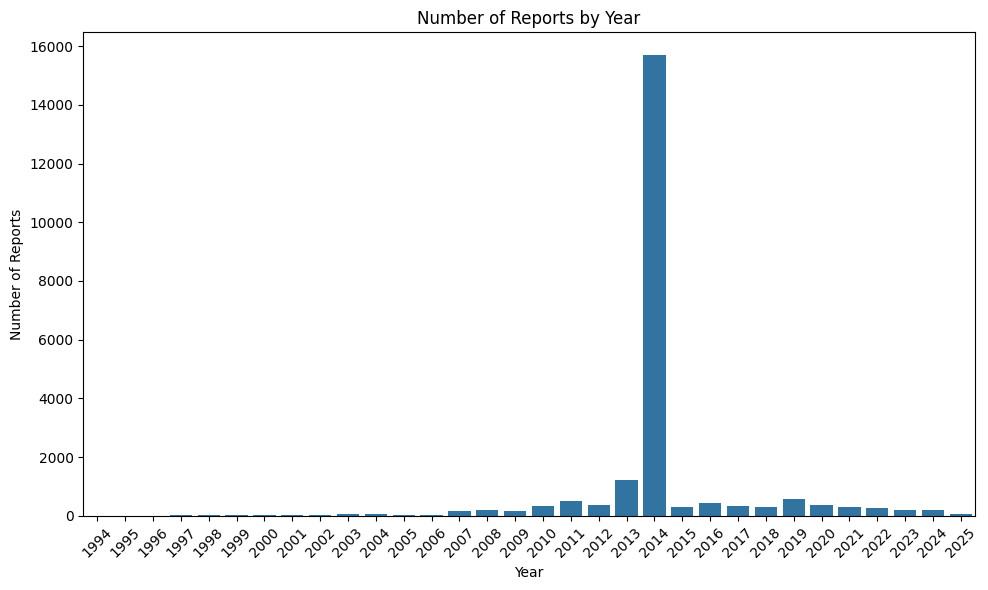

In [10]:
# Visualize the number of reported events by year
combined_df_cleaned['year_received'] = combined_df_cleaned['date_received'].dt.year

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df_cleaned, x='year_received', order=sorted(combined_df_cleaned['year_received'].dropna().unique()))
plt.title('Number of Reports by Year')
plt.xlabel('Year')
plt.ylabel('Number of Reports')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\bahad\AppData\Local\Temp\ipykernel_13248\2579524835.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=yearly_counts.index, y=yearly_counts.values, palette="Blues_d")


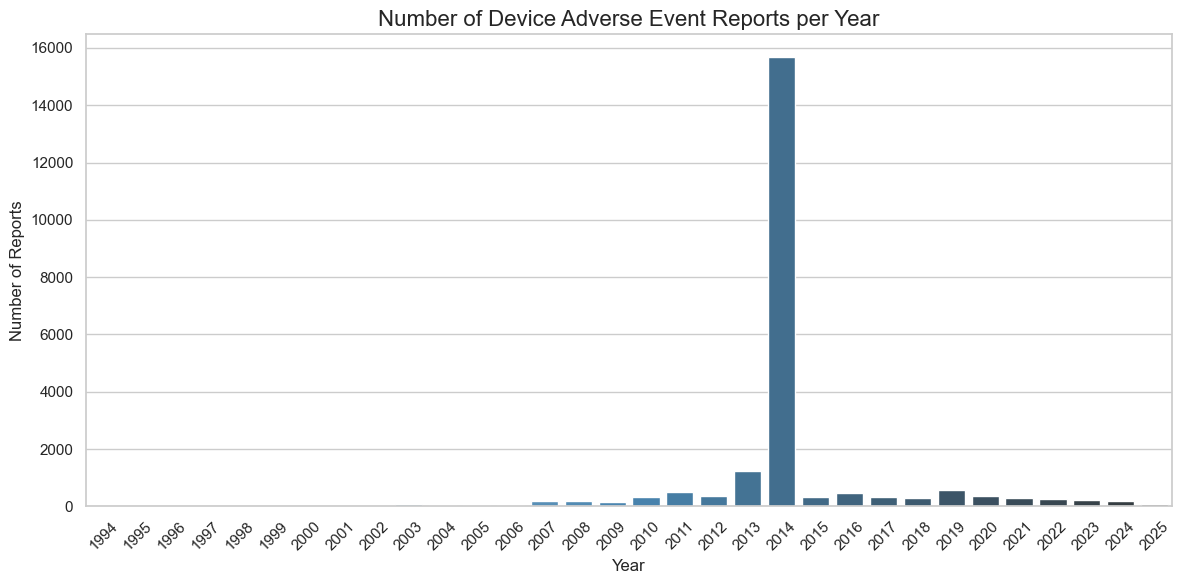

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Ensure 'date_received' is in datetime format
combined_df["date_received"] = pd.to_datetime(combined_df["date_received"], errors="coerce")

# Extract year from 'date_received'
combined_df["year_received"] = combined_df["date_received"].dt.year

# Count number of reports per year
yearly_counts = combined_df["year_received"].value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=yearly_counts.index, y=yearly_counts.values, palette="Blues_d")
plt.title("Number of Device Adverse Event Reports per Year", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Number of Reports")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




# 📌 Most Common Event Types Reported

C:\Users\bahad\AppData\Local\Temp\ipykernel_13248\161803032.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_event_types.values, y=top_event_types.index, palette="magma")


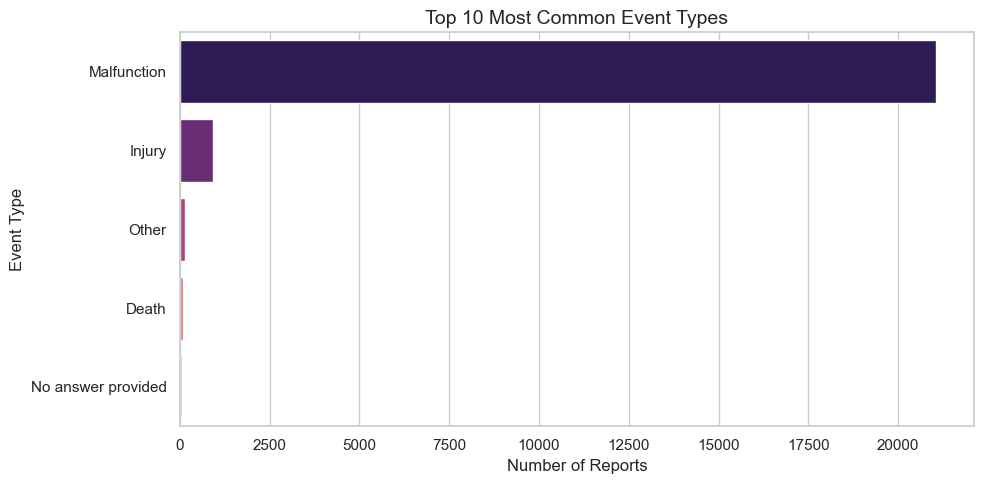

In [16]:
# Count top 10 most common event types
top_event_types = combined_df["event_type"].value_counts().head(10)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=top_event_types.values, y=top_event_types.index, palette="magma")
plt.title("Top 10 Most Common Event Types", fontsize=14)
plt.xlabel("Number of Reports")
plt.ylabel("Event Type")
plt.tight_layout()
plt.show()


# 📌 Top 10 Reporter Occupation Codes

C:\Users\bahad\AppData\Local\Temp\ipykernel_13248\2035165941.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_occupations.values, y=top_occupations.index, palette="coolwarm")


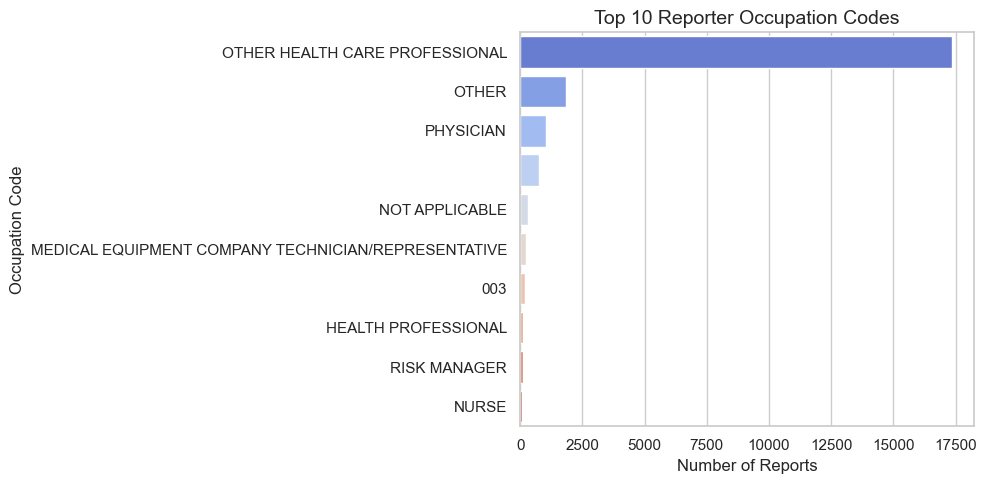

In [17]:
# Count top reporter occupation codes
top_occupations = combined_df["reporter_occupation_code"].value_counts().head(10)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=top_occupations.values, y=top_occupations.index, palette="coolwarm")
plt.title("Top 10 Reporter Occupation Codes", fontsize=14)
plt.xlabel("Number of Reports")
plt.ylabel("Occupation Code")
plt.tight_layout()
plt.show()


# 📌 Distribution of Report Submission Delays
## (How long after the event did the report reach the manufacturer?)

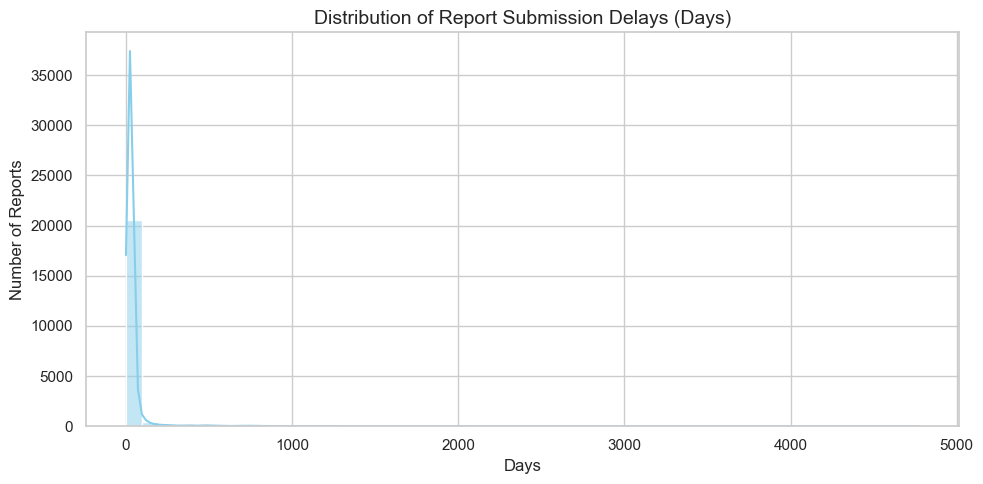

In [20]:
# Convert date columns to datetime format
combined_df["date_report"] = pd.to_datetime(combined_df["date_report"], errors="coerce")
combined_df["date_of_event"] = pd.to_datetime(combined_df["date_of_event"], errors="coerce")

# Calculate delay in days
combined_df["report_delay"] = (combined_df["date_report"] - combined_df["date_of_event"]).dt.days

# Drop negative or missing delays
delay_data = combined_df["report_delay"].dropna()
delay_data = delay_data[delay_data >= 0]

# Plot
plt.figure(figsize=(10, 5))
sns.histplot(delay_data, bins=50, kde=True, color="skyblue")
plt.title("Distribution of Report Submission Delays (Days)", fontsize=14)
plt.xlabel("Days")
plt.ylabel("Number of Reports")
plt.tight_layout()
plt.show()



# Conclusion

In this project, we collected adverse event report data from the openFDA API for medical devices. We performed data cleaning, exploratory analysis, and visualizations to better understand trends and reporting delays. This pipeline demonstrates how to combine web scraping, API interaction, and data analysis into a single workflow.